## Data Description

https://www.kaggle.com/brijbhushannanda1979/bigmart-sales-data

- Item_Identifier: Unique product ID

- Item_Weight: Weight of product

- Item_Fat_Content: Whether the product is low fat or not

- Item_Visibility: The % of total display area of all products in a store allocated to the particular product

- Item_Type: The category to which the product belongs

- Item_MRP: Maximum Retail Price (list price) of the product

- Outlet_Identifier: Unique store ID

- Outlet_Establishment_Year: The year in which store was established

- Outlet_Size: The size of the store in terms of ground area covered

- Outlet_Location_Type: The type of city in which the store is located

- Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket

- Item_Outlet_Sales: Sales of the product in the particulat store. This is the outcome variable to be predicted.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re

In [2]:
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
train_df = pd.read_csv("train.csv")

In [6]:
train_df.shape

(8523, 12)

In [7]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [8]:
test_df = pd.read_csv("test.csv")

In [9]:
test_df.shape

(5681, 11)

In [10]:
test_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [11]:
#Checking the memory usage of both dataframes

print("Train set: {:2.2f} Mb".format(train_df.memory_usage().sum() / 1024**2))
print("Test set: {:2.2f} Mb".format(test_df.memory_usage().sum() / 1024**2))

Train set: 0.78 Mb
Test set: 0.48 Mb


These dataframes are small and their memory usage does not have to be reduced.

## Handling Missing Values

In [12]:
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


Only the Item_Weight and Outlet_Size columns have missing values. Let's check if they can be derived from the other columns.

In [14]:
#Creating a boolean series with True for every null value in the Item_Weight column
bool_ItemWeight = pd.isnull(train_df['Item_Weight'])

#Viewing the Item_Identifier and Item_Weight columns where the Item_Weight is null
train_df[['Item_Identifier', 'Item_Weight']][bool_ItemWeight]

,Item_Identifier,Item_Weight
7,FDP10,NaN
18,DRI11,NaN
21,FDW12,NaN
23,FDC37,NaN
29,FDC14,NaN
...,...,...
8485,DRK37,NaN
8487,DRG13,NaN
8488,NCN14,NaN
8490,FDU44,NaN


In [15]:
#Grouping the train dataframe by the Item_Identifier column
item_groupby = train_df.groupby(['Item_Identifier'])

In [16]:
#Checking the Item_Weight values for the Item_Identifier value 'DRI11'
item_groupby.get_group('DRI11')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
1366,DRI11,NaN,Low Fat,0.060237,Hard Drinks,115.9834,OUT019,1985,Small,Tier 1,Grocery Store,345.5502
3127,DRI11,8.26,Low Fat,0.034458,Hard Drinks,113.3834,OUT049,1999,Medium,Tier 1,Supermarket Type1,2073.3012
5310,DRI11,8.26,Low Fat,0.057586,Hard Drinks,113.7834,OUT010,1998,NaN,Tier 3,Grocery Store,115.1834
7022,DRI11,8.26,Low Fat,0.034398,Hard Drinks,115.7834,OUT035,2004,Small,Tier 2,Supermarket Type1,2073.3012
7192,DRI11,8.26,Low Fat,0.034544,Hard Drinks,116.0834,OUT018,2009,Medium,Tier 3,Supermarket Type2,1267.0174
8483,DRI11,8.26,Low Fat,0.034474,Hard Drinks,117.0834,OUT045,2002,NaN,Tier 2,Supermarket Type1,1612.5676


As expected, we can get item weights from the item identifier column. But we need to check that the item weight is constant for a given item before imputing them in the null values.

In [17]:
#Checking the number of unique item types
train_df['Item_Identifier'].describe()

count      8523
unique     1559
top       FDG33
freq         10
Name: Item_Identifier, dtype: object

Since the number of unique items is very high, let's create a mapping of item identifiers and its correct item weight.

In [18]:
#Creating an empty dict object to store the mapping
item_id_weight_dict = dict()
type(item_id_weight_dict)

dict

In [19]:
#Making an empty list to store item identifiers for which item weights weren't found
leftover_item_identifiers = []


#Looping through the list of item identifiers
for i in train_df['Item_Identifier'].unique().tolist():
    
    #Getting all the item weights for the current item
    weight = train_df['Item_Weight'][(pd.notnull(train_df['Item_Weight'])) & (train_df['Item_Identifier']==i)]
    
    #Checking if there is only one unique item weight for the current item
    if len(set(weight))==1:
        
        #Adding the item identifier and its weight to the mapping
        item_id_weight_dict[i] = list(set(weight))[0]
    
    #Noting the items that do not have a single unique item weight or fail that test for some other reason
    else:
        leftover_item_identifiers.append(i)
        

Now, we can use this mapping to impute the missing Item_Weight values.

In [20]:
#Imputing the Item_Weight values wherever it is null in the train set
train_df['Item_Weight'] = train_df.apply(lambda x: item_id_weight_dict[x['Item_Identifier']] if ((pd.isnull(x['Item_Weight'])) 
                             and (x['Item_Identifier'] in(item_id_weight_dict.keys()))) else x['Item_Weight'], axis=1)

In [21]:
#Doing the same in the test set
test_df['Item_Weight'] = test_df.apply(lambda x: item_id_weight_dict[x['Item_Identifier']] if ((pd.isnull(x['Item_Weight'])) 
                             and (x['Item_Identifier'] in(item_id_weight_dict.keys()))) else x['Item_Weight'], axis=1)

Let's check if there are any null values in the Item_Weight column.

In [22]:
train_df['Item_Weight'].isnull().sum()

4

In [23]:
test_df['Item_Weight'].isnull().sum()

1

Let's check the rows that still have null values in the Item_Weight column.

In [24]:
# #Viewing the identifier and weight columns where Item_Weight is null
train_df[['Item_Identifier', 'Item_Weight']][pd.isnull(train_df['Item_Weight'])]

,Item_Identifier,Item_Weight
927,FDN52,NaN
1922,FDK57,NaN
4187,FDE52,NaN
5022,FDQ60,NaN


In [25]:
#Let's view all the rows with these item identifiers
print("FDN52: ",train_df.loc[train_df['Item_Identifier']=='FDN52', 'Item_Weight'])
print("FDK57: ",train_df.loc[train_df['Item_Identifier']=='FDK57', 'Item_Weight'])
print("FDE52: ",train_df.loc[train_df['Item_Identifier']=='FDE52', 'Item_Weight'])
print("FDQ60: ",train_df.loc[train_df['Item_Identifier']=='FDQ60', 'Item_Weight'])

FDN52:  927   NaN
Name: Item_Weight, dtype: float64
FDK57:  1922   NaN
Name: Item_Weight, dtype: float64
FDE52:  4187   NaN
Name: Item_Weight, dtype: float64
FDQ60:  5022   NaN
Name: Item_Weight, dtype: float64


The weight of these items is not present in the train set. Checking if they are present in the test set.

In [26]:
#Viewing the rows with the specified item identifier
print("FDN52: ",test_df.loc[test_df['Item_Identifier']=='FDN52', 'Item_Weight'])
print("FDK57: ",test_df.loc[test_df['Item_Identifier']=='FDK57', 'Item_Weight'])
print("FDE52: ",test_df.loc[test_df['Item_Identifier']=='FDE52', 'Item_Weight'])
print("FDQ60: ",test_df.loc[test_df['Item_Identifier']=='FDQ60', 'Item_Weight'])

FDN52:  396     9.395
1547    9.395
2963    9.395
3070    9.395
3171    9.395
3579    9.395
4252    9.395
5271    9.395
Name: Item_Weight, dtype: float64
FDK57:  1163    10.195
1501    10.195
1576    10.195
1793    10.195
2438    10.195
4297    10.195
4806    10.195
4942    10.195
Name: Item_Weight, dtype: float64
FDE52:  59      10.395
144     10.395
502     10.395
1081    10.395
1980    10.395
5196    10.395
5221    10.395
Name: Item_Weight, dtype: float64
FDQ60:  440     6.195
1059    6.195
1713    6.195
1724      NaN
2044    6.195
4154    6.195
4524    6.195
5535    6.195
Name: Item_Weight, dtype: float64


These weights (from the test set) can be imputed in the train set.

In [27]:
#Making a list of item identifiers whose weights weren't found in the train set
items_in_test = ['FDN52', 'FDK57', 'FDE52', 'FDQ60']

In [28]:
#Looping through this list
for i in items_in_test:
    
    #Getting all the item weights for the current item
    weight = test_df['Item_Weight'][(pd.notnull(test_df['Item_Weight'])) & (test_df['Item_Identifier']==i)]
    
    #Checking if there is only one unique item weight for the current item
    if len(set(weight))==1:
        
        #Adding the item identifier and its weight to the mapping
        item_id_weight_dict[i] = list(set(weight))[0]
        
                
        #Imputing this value in the train and test sets
        train_df['Item_Weight'] = train_df.apply(lambda x: item_id_weight_dict[i] if ((x['Item_Identifier']==i) & 
                                                          (pd.isnull(x['Item_Weight']))) else x['Item_Weight'], axis=1)
        
        test_df['Item_Weight'] = test_df.apply(lambda x: item_id_weight_dict[i] if ((x['Item_Identifier']==i) & 
                                                          (pd.isnull(x['Item_Weight']))) else x['Item_Weight'], axis=1)

        
        print("Weight imputed for the item: ", i)
        
    #Noting the items that do not have a single unique item weight or fail that test for some other reason
    else:
        leftover_item_identifiers.append(i)
    

Weight imputed for the item:  FDN52
Weight imputed for the item:  FDK57
Weight imputed for the item:  FDE52
Weight imputed for the item:  FDQ60


Let's check for null values again.

In [29]:
train_df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [30]:
test_df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

The missing values in the Item_Weight column have been imputed in both the train and test sets. Next, checking the Outlet_Size column in the train set.

In [31]:
#Viewing the outlet size and outlet type columns where Outlet_Size is null
train_df[['Outlet_Size', 'Outlet_Type', 'Outlet_Identifier']][pd.notnull(train_df['Outlet_Size'])]

,Outlet_Size,Outlet_Type,Outlet_Identifier
0,Medium,Supermarket Type1,OUT049
1,Medium,Supermarket Type2,OUT018
2,Medium,Supermarket Type1,OUT049
4,High,Supermarket Type1,OUT013
5,Medium,Supermarket Type2,OUT018
...,...,...,...
8517,Small,Supermarket Type1,OUT046
8518,High,Supermarket Type1,OUT013
8520,Small,Supermarket Type1,OUT035
8521,Medium,Supermarket Type2,OUT018


It looks like Outlet_Size can be obtained from Outlet_Identifier, especially since the Outlet_Identifier column does not have any null values.

In [32]:
#Checking the number of outlets that present in either the train or test set, but not both
set(train_df['Outlet_Identifier'].unique()).symmetric_difference(set(test_df['Outlet_Identifier'].unique()))

set()

The same outlets are present in both train and test sets.

In [33]:
#Creating a list of outlet identifiers

outlet_identifiers_list = list(set(train_df['Outlet_Identifier']))
len(outlet_identifiers_list)

10

Let's create a mapping of outlet size to outlet identifier for the above outlets, and impute the missing values.

In [34]:
#Initializing dictionaries to store the outlet size for each outlet identifier
size_identifier_mapping = dict()
multiple_sizes_mapping = dict()

#Looping through the list of outlets with missing values in the outlet size column
for i in outlet_identifiers_list:
    
    #Getting all the outlet sizes for the current outlet identifier
    size_series = train_df['Outlet_Size'][(pd.notnull(train_df['Outlet_Size'])) & (train_df['Outlet_Identifier']==i)]
    
    
    #Checking if there is only one unique Outlet_Size for an outlet
    if len(list(set(size_series)))==1:
        
        #Adding the outlet size to the dictionary for mapping
        size_identifier_mapping[i] = list(set(size_series))[0]
        
        train_df['Outlet_Size'] = train_df.apply(lambda x: size_identifier_mapping[i] if ((x['Outlet_Identifier']==i) & 
                                                              (pd.isnull(x['Outlet_Size']))) else x['Outlet_Size'], axis=1)
        
        test_df['Outlet_Size'] = test_df.apply(lambda x: size_identifier_mapping[i] if ((x['Outlet_Identifier']==i) & 
                                                              (pd.isnull(x['Outlet_Size']))) else x['Outlet_Size'], axis=1)

        
    #If there is no single unique Outlet_Size in the train set      
    else:
        #Getting all the outlet sizes for the current outlet identifier from the test set
        size_series = test_df['Outlet_Size'][(pd.notnull(test_df['Outlet_Size'])) & (test_df['Outlet_Identifier']==i)]
        
        #Checking for a single unique Outlet_Size
        if len(list(set(size_series)))!=1:
            
            #Adding outlet identifier to dictionary
            multiple_sizes_mapping[i] = list(set(size_series))
            print("There is no unique outlet size in the dataset for outlet {}".format(i))
        
        else:
            size_identifier_mapping[i] = list(set(size_series))[0]
            print("Outlet size found in test size for {}; not imputed".format(i))
    

There is no unique outlet size in the dataset for outlet OUT045
There is no unique outlet size in the dataset for outlet OUT010
There is no unique outlet size in the dataset for outlet OUT017


In [35]:
#Putting these outlet identifiers in a list
missing_sizes = list(multiple_sizes_mapping.keys())
missing_sizes

['OUT045', 'OUT010', 'OUT017']

In [36]:
#Checking if there are multiple outlet sizes for these outlets
for m in missing_sizes:
    print("Oulet ID: ", m)
    print("\n")
    print("Train set")
    print(train_df[(train_df['Outlet_Identifier']==m) & (pd.notnull(train_df['Outlet_Size']))])
    print("\n")
    print("Test set")
    print(test_df[(test_df['Outlet_Identifier']==m) & (pd.notnull(test_df['Outlet_Size']))])
    print("\n\n")

Oulet ID:  OUT045


Train set
Empty DataFrame
Columns: [Item_Identifier, Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP, Outlet_Identifier, Outlet_Establishment_Year, Outlet_Size, Outlet_Location_Type, Outlet_Type, Item_Outlet_Sales]
Index: []


Test set
Empty DataFrame
Columns: [Item_Identifier, Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP, Outlet_Identifier, Outlet_Establishment_Year, Outlet_Size, Outlet_Location_Type, Outlet_Type]
Index: []



Oulet ID:  OUT010


Train set
Empty DataFrame
Columns: [Item_Identifier, Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP, Outlet_Identifier, Outlet_Establishment_Year, Outlet_Size, Outlet_Location_Type, Outlet_Type, Item_Outlet_Sales]
Index: []


Test set
Empty DataFrame
Columns: [Item_Identifier, Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP, Outlet_Identifier, Outlet_Establishment_Year, Outlet_Size, Outlet_Location_Type, Outlet_Type]
Index: []



Oulet ID: 

The outlet size is not available for these outlets in both the train and test sets. Therefore, let's impute the mode outlet size for each outlet type.

In [37]:
#Grouping by outlet type
grouped_df = train_df[['Outlet_Type', 'Outlet_Size']].groupby('Outlet_Type')

In [38]:
#Checking the outlet size mode for each outlet type
for key, item in grouped_df:
    print("Key: ", key)
    print(grouped_df.get_group(key).mode(), "\n\n")

Key:  Grocery Store
     Outlet_Type Outlet_Size
0  Grocery Store       Small 


Key:  Supermarket Type1
         Outlet_Type Outlet_Size
0  Supermarket Type1       Small 


Key:  Supermarket Type2
         Outlet_Type Outlet_Size
0  Supermarket Type2      Medium 


Key:  Supermarket Type3
         Outlet_Type Outlet_Size
0  Supermarket Type3      Medium 




In [39]:
#Checking the number of medium, small, high, and null values in the outlet size column (in both train and test sets)
print("Train set\n" )
print(train_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in train set: ", len(train_df[train_df['Outlet_Size'].isnull()]))
print("\n\nTest set\n" )
print(test_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in test set: ", len(test_df[test_df['Outlet_Size'].isnull()]))

Train set

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64 

Number of null values in train set:  2410


Test set

Medium    1862
Small     1592
High       621
Name: Outlet_Size, dtype: int64 

Number of null values in test set:  1606


Since small and medium outlet sizes are the modes for some outlet types, and high outlet size is not the mode for any outlet type, the value counts should increase only for these two outlet types (after imputation).

In [40]:
#Creating a list of outlet types
outlet_type_list = list(train_df['Outlet_Type'].unique())
outlet_type_list

['Supermarket Type1',
 'Supermarket Type2',
 'Grocery Store',
 'Supermarket Type3']

In [41]:
#Looping through the list of outlet types to impute the mode outlet size for that type
for i in outlet_type_list:
    
    #Outlet types where the mode outlet size is 'Small'
    if ((i == 'Grocery Store') | (i == 'Supermarket Type1')):
        train_df.loc[(train_df['Outlet_Type']==i) & (pd.isnull(train_df['Outlet_Size'])), 'Outlet_Size'] = 'Small'
        test_df.loc[(test_df['Outlet_Type']==i) & (pd.isnull(test_df['Outlet_Size'])), 'Outlet_Size'] = 'Small'
    
    #Outlet types where the mode outlet size is 'Medium'
    else:
        train_df.loc[(train_df['Outlet_Type']==i) & (pd.isnull(train_df['Outlet_Size'])), 'Outlet_Size'] = 'Medium'
        test_df.loc[(test_df['Outlet_Type']==i) & (pd.isnull(test_df['Outlet_Size'])), 'Outlet_Size'] = 'Medium'


In [42]:
#Checking the same numbers after imputation
print("Train set\n" )
print(train_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in train set: ", len(train_df[train_df['Outlet_Size'].isnull()]))
print("\n\nTest set\n" )
print(test_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in test set: ", len(test_df[test_df['Outlet_Size'].isnull()]))

Train set

Small     4798
Medium    2793
High       932
Name: Outlet_Size, dtype: int64 

Number of null values in train set:  0


Test set

Small     3198
Medium    1862
High       621
Name: Outlet_Size, dtype: int64 

Number of null values in test set:  0


As expected, only the small and medium value counts have gone up.

In [43]:
#Checking if there are any null values
print(train_df.isnull().sum(), "\n\n")
print(test_df.isnull().sum())

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64 


Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64


#### Deleting the existing variables that are not necessary

In [44]:
%who

CatBoostRegressor	 DecisionTreeRegressor	 FeatureHasher	 GridSearchCV	 KFold	 LGBMRegressor	 LinearRegression	 OneHotEncoder	 RandomForestRegressor	 
StandardScaler	 StratifiedKFold	 XGBRegressor	 bool_ItemWeight	 cb	 cross_val_score	 gc	 grouped_df	 i	 
item	 item_groupby	 item_id_weight_dict	 items_in_test	 key	 leftover_item_identifiers	 lgb	 m	 mean_squared_error	 
missing_sizes	 mode	 multiple_sizes_mapping	 np	 outlet_identifiers_list	 outlet_type_list	 pd	 plt	 r2_score	 
re	 size_identifier_mapping	 size_series	 sns	 test_df	 time	 train_df	 train_test_split	 warnings	 
weight	 


In [45]:
del (bool_ItemWeight, item, item_groupby, item_id_weight_dict, items_in_test, 
     leftover_item_identifiers, multiple_sizes_mapping, outlet_identifiers_list, outlet_type_list, 
     size_identifier_mapping, size_series)

In [46]:
#Triggering garbage collection

gc.collect()

100

In [47]:
#Creating a backup of the train and test sets
train_df_backup = train_df.copy()
test_df_backup = test_df.copy()

## Data Exploration and Visualization

In [49]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


I'll go through the categorical columns first.

#### Item_Identifier

In [50]:
#Checking the number of categories in the item identifier column
len(train_df['Item_Identifier'].unique())

1559

This is far too many categories. Let's check if there is a higher category level that we can use to reduce the number of categories.

In [51]:
train_df.head(50)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,19.000,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,Small,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,Small,Tier 2,Supermarket Type1,4710.5350


Let's check the number of categories if the first three characters of this column are used.

In [52]:
first_three = train_df['Item_Identifier'].apply(lambda x: re.match('^.{3}', x).group())
print(first_three[0:10])
print("Number of categories: ", len(first_three.unique()))

0    FDA
1    DRC
2    FDN
3    FDX
4    NCD
5    FDP
6    FDO
7    FDP
8    FDH
9    FDU
Name: Item_Identifier, dtype: object
Number of categories:  71


71 is still too many categories. Let's check the number of categories if the first two characters are used.

In [53]:
first_two = train_df['Item_Identifier'].apply(lambda x: re.match('^.{2}', x).group())
print(first_two[0:10])
print("Number of categories: ", len(first_two.unique()))

0    FD
1    DR
2    FD
3    FD
4    NC
5    FD
6    FD
7    FD
8    FD
9    FD
Name: Item_Identifier, dtype: object
Number of categories:  3


It looks like the items can broadly be divided into three categories:
- FD -- Food
- NC -- Non-Consumable
- DR -- Drinks

I'll replace each item identifier with the first two characters.

In [54]:
#Retaining only the first two characters in the item identifier column
train_df['Item_Identifier'] = train_df['Item_Identifier'].apply(lambda x: re.match('^.{2}', x).group())
test_df['Item_Identifier'] = test_df['Item_Identifier'].apply(lambda x: re.match('^.{2}', x).group())

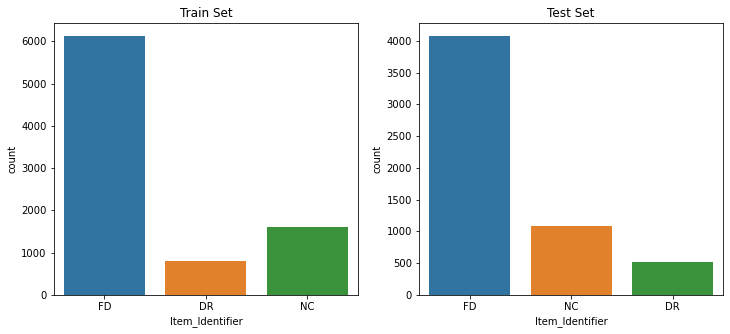

In [55]:
#Plotting the number of items that belong to these three categories

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Item_Identifier'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Item_Identifier'])

plt.show()

Most of the items sold are food.

#### Item_Fat_Content

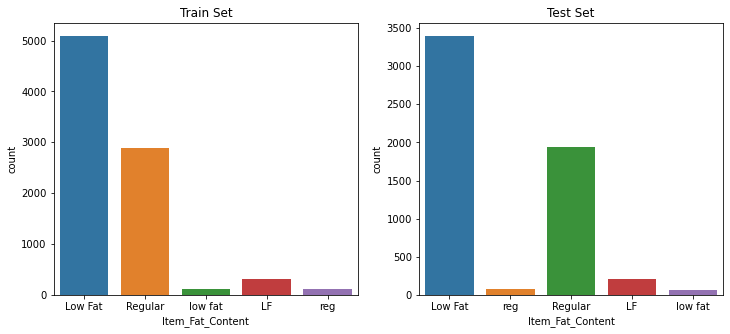

In [56]:
#Plotting the number of items in the Item_Fat_Content column

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Item_Fat_Content'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Item_Fat_Content'])

plt.show()

It looks like 'LF' and 'low fat' are the same. This also applies to 'reg' and 'Regular'.

In [57]:
#Substituting 'Low Fat' inplace of 'low fat' and 'LF'

train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: re.sub('low fat', 'Low Fat', x))
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: re.sub('LF', 'Low Fat', x))

test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: re.sub('low fat', 'Low Fat', x))
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: re.sub('LF', 'Low Fat', x))


#Substituting 'Regular' inplace of 'reg'

train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: re.sub('reg', 'Regular', x))
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: re.sub('reg', 'Regular', x))

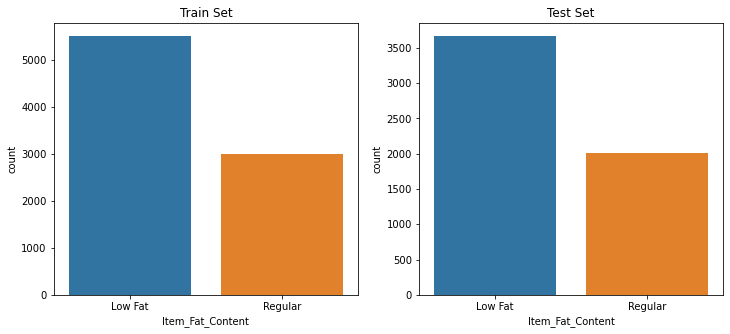

In [58]:
#Checking the Item_Fat_Content column again

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Item_Fat_Content'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Item_Fat_Content'])

plt.show()

Low fat items have sold in greater numbers than regular items.

#### Item_Type

In [59]:
print(train_df['Item_Type'].unique(), "\n")
print("Number of item types: ", len(train_df['Item_Type'].unique()))

['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood'] 

Number of item types:  16


#### Outlet_Identifier

In [60]:
print(train_df['Outlet_Identifier'].unique(), "\n")
print("Number of outlets: ", len(train_df['Outlet_Identifier'].unique()))

['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019'] 

Number of outlets:  10


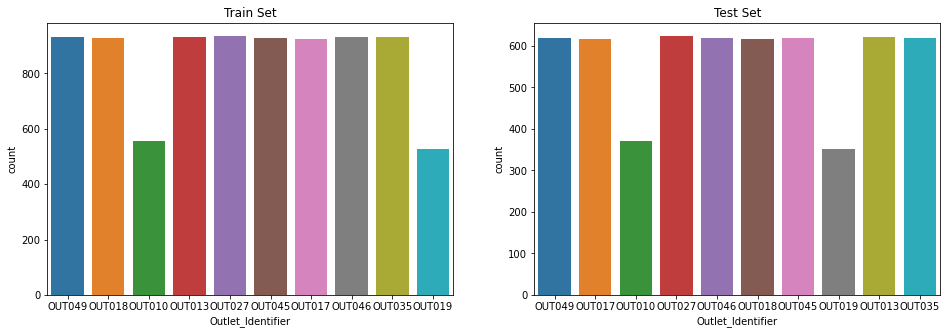

In [61]:
#Checking the Outlet_Identifier column

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Identifier'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Identifier'])

plt.show()

#### Outlet_Establishment_Year

In [64]:
print(train_df['Outlet_Establishment_Year'].unique(), "\n")
print("Number of outlet establishment years: ", len(train_df['Outlet_Establishment_Year'].unique()))

[1999 2009 1998 1987 1985 2002 2007 1997 2004] 

Number of outlet establishment years:  9


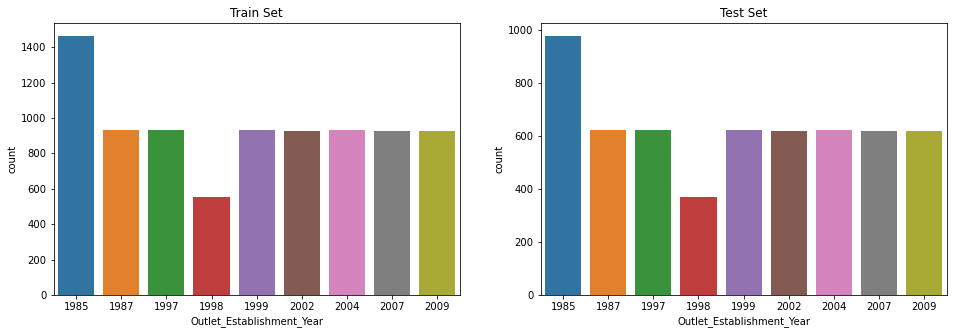

In [65]:
#Visualizing the Outlet_Establishment_Year column

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Establishment_Year'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Establishment_Year'])

plt.show()

Since the year of establishing an outlet cannot be used directly in a model, I'll convert these years into age of the outlet.

In [66]:
#I'll consider the age of the outlet in the year 2010
train_df['Outlet_Establishment_Year'] = 2010 - train_df['Outlet_Establishment_Year']
test_df['Outlet_Establishment_Year'] = 2010 - test_df['Outlet_Establishment_Year']

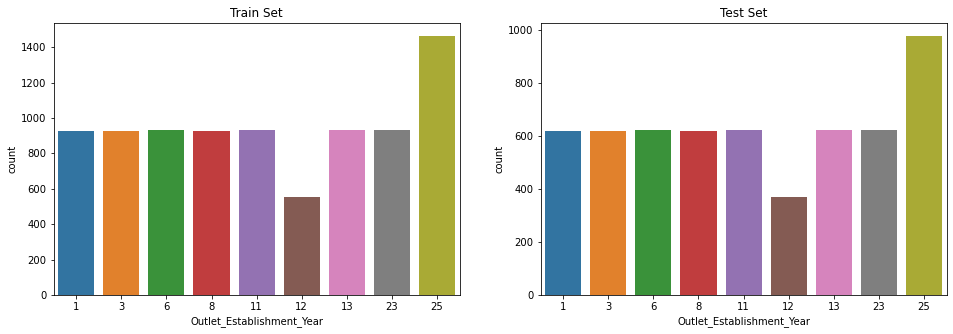

In [67]:
#Checking the Outlet_Establishment_Year column again

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Establishment_Year'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Establishment_Year'])

plt.show()

As we can see from these graphs, most outlets were established in 1985 and were 25 years old in the year 2010.

#### Outlet_Size

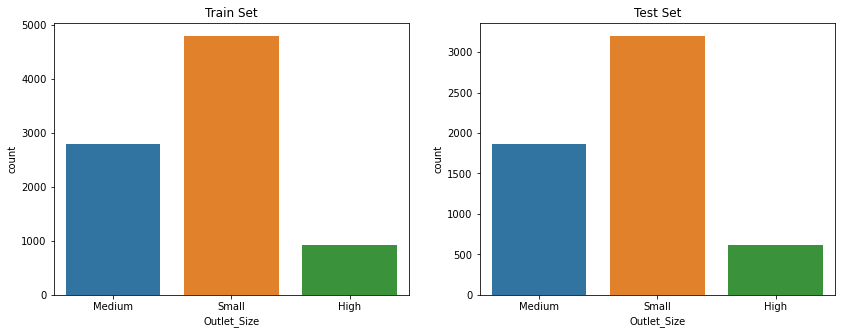

In [68]:
#Checking the Outlet_Size column

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Size'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Size'])

plt.show()

#### Outlet_Location_Type

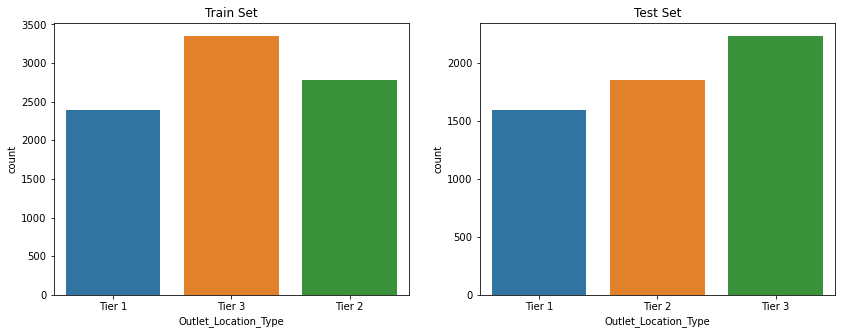

In [69]:
#Checking the Outlet_Location_Type column

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Location_Type'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Location_Type'])

plt.show()

#### Outlet_Type

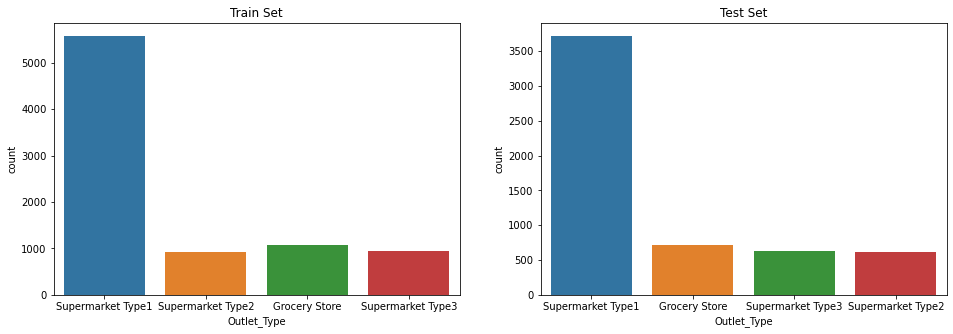

In [70]:
#Checking the Outlet_Type column

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Type'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Type'])

plt.show()

Most of the data points come from outlets that are Supermarket Type1.

#### Continous Variables

In [71]:
#Checking the spread of continous variables
train_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.873623,0.066132,140.992782,12.168133
std,4.645893,0.051598,62.275067,8.371760
min,4.555000,0.000000,31.290000,1.000000
25%,8.785000,0.026989,93.826500,6.000000
50%,12.600000,0.053931,143.012800,11.000000
75%,16.850000,0.094585,185.643700,23.000000
max,21.350000,0.328391,266.888400,25.000000


There don't appear to be any outliers. The minimum value in the Item_Visibility column is zero. If the item is on display in the outlet, the visibility percentage should not be zero. I'll check if Item_Outlet_Sales = 0 when Item_Visibility = 0, as this would indicate that the item is not on the shelves of the outlet.

In [72]:
#Checking if an item is not on the shelves of an outlet when the visibility is zero
train_df[(train_df['Item_Visibility']==0) & (train_df['Item_Outlet_Sales']==0)]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


It looks like the item is present on the shelf, as it has a corresponding sales figure.

In [75]:
#Checking if the item visibility is zero only in a particular outlet

print("Total number of outlets: ", len(train_df['Outlet_Identifier'].unique()))
print("Number of outlets with item visibility zero for an item: ", 
      len(train_df['Outlet_Identifier'][train_df['Item_Visibility']==0].unique()))

Total number of outlets:  10
Number of outlets with item visibility zero for an item:  10


In [76]:
#Checking if the item visibility is zero only for a particular item

print("Total number of items: ", len(train_df['Item_Type'].unique()))
print("Number of items with item visibility zero: ", 
      len(train_df['Item_Type'][train_df['Item_Visibility']==0].unique()))

Total number of items:  16
Number of items with item visibility zero:  16


It looks like all items have zero visibility in one outlet or another. Similarly, all outlets have at least one item with zero visibility. This is unlikely to be a data entry error and more likely to be a result of rounding values lower than a threshold value to zero.

In [78]:
#Checking for the lowest non-zero values in the Item_Visibility column
print("Number of rows where Item_Visibility lies between 0 and 0.01: ", train_df[(train_df['Item_Visibility'] < 0.01) & (train_df['Item_Visibility'] > 0)].shape[0])
print("Number of rows where Item_Visibility lies between 0 and 0.001: ", train_df[(train_df['Item_Visibility'] < 0.001) & (train_df['Item_Visibility'] > 0)].shape[0])

Number of rows where Item_Visibility lies between 0 and 0.01:  206
Number of rows where Item_Visibility lies between 0 and 0.001:  0


It looks like values lower than 0.001 have been rounded to zero in this column. I'll add 0.001 to all values of this column, as Item_Visibility is a percentage and 0.001 = 0.1%

In [79]:
#Checking if the test set also has zero values in the Item_Visibility column
test_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,5681.000000,5681.000000,5681.000000,5681.000000
mean,12.672996,0.065684,141.023273,12.171097
std,4.658256,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1.000000
25%,8.615000,0.027047,94.412000,6.000000
50%,12.350000,0.054154,141.415400,11.000000
75%,16.700000,0.093463,186.026600,23.000000
max,21.350000,0.323637,266.588400,25.000000


Adding 0.001 to all Item_Visibility values.

In [80]:
train_df['Item_Visibility'] = train_df['Item_Visibility'] + 0.001
test_df['Item_Visibility'] = test_df['Item_Visibility'] + 0.001

#### Item_Outlet_Sales

In [81]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FD,9.30,Low Fat,0.017047,Dairy,249.8092,OUT049,11,Medium,Tier 1,Supermarket Type1,3735.1380
1,DR,5.92,Regular,0.020278,Soft Drinks,48.2692,OUT018,1,Medium,Tier 3,Supermarket Type2,443.4228
2,FD,17.50,Low Fat,0.017760,Meat,141.6180,OUT049,11,Medium,Tier 1,Supermarket Type1,2097.2700
3,FD,19.20,Regular,0.001000,Fruits and Vegetables,182.0950,OUT010,12,Small,Tier 3,Grocery Store,732.3800
4,NC,8.93,Low Fat,0.001000,Household,53.8614,OUT013,23,High,Tier 3,Supermarket Type1,994.7052


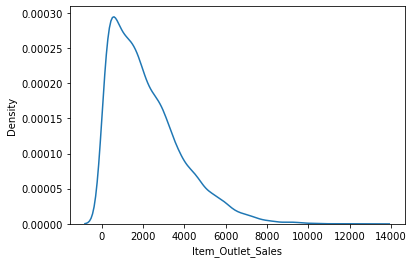

In [83]:
sns.distplot(train_df['Item_Outlet_Sales'], hist=False)
plt.show()

This is not close to a normal distribution. I'll try transforming the variable and plotting their graphs to see the transformed distribution.

## Data Preparation

In [84]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import yeojohnson

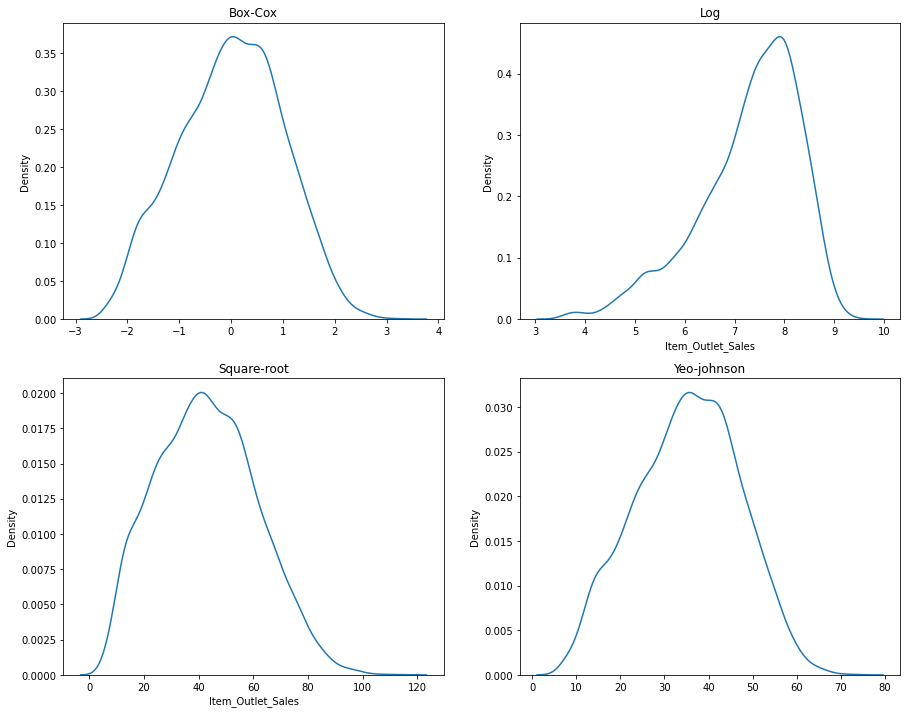

In [87]:
#Checking the plots for different transformations

plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.title("Box-Cox")
pt = PowerTransformer(method='box-cox')
#Using pd.DataFrame as the input needs to be of the shape (n, 1) and not (n, )
sns.distplot(pt.fit_transform(pd.DataFrame(train_df['Item_Outlet_Sales'])), hist=False)

plt.subplot(2, 2, 2)
plt.title("Log")
sns.distplot(np.log1p(train_df['Item_Outlet_Sales']), hist=False)

plt.subplot(2, 2, 3)
plt.title("Square-root")
sns.distplot(train_df['Item_Outlet_Sales']**(1/2), hist=False)

plt.subplot(2, 2, 4)
plt.title("Yeo-johnson")
yf_target, lam = yeojohnson(train_df['Item_Outlet_Sales'])
sns.distplot(yf_target, hist=False)


plt.show()

Box-cox and yeo-johnson transformations appear to yield the best transformations. I'll use the box-cox transformation to modify the target variable.

In [88]:
#Transforming the target variable
train_df['Item_Outlet_Sales'] = pt.fit_transform(pd.DataFrame(train_df['Item_Outlet_Sales']))

In [89]:
train_df.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FD,9.300,Low Fat,0.017047,Dairy,249.8092,OUT049,11,Medium,Tier 1,Supermarket Type1,0.984978
1,DR,5.920,Regular,0.020278,Soft Drinks,48.2692,OUT018,1,Medium,Tier 3,Supermarket Type2,-1.217837
2,FD,17.500,Low Fat,0.017760,Meat,141.6180,OUT049,11,Medium,Tier 1,Supermarket Type1,0.220282
3,FD,19.200,Regular,0.001000,Fruits and Vegetables,182.0950,OUT010,12,Small,Tier 3,Grocery Store,-0.834969
4,NC,8.930,Low Fat,0.001000,Household,53.8614,OUT013,23,High,Tier 3,Supermarket Type1,-0.566490
5,FD,10.395,Regular,0.001000,Baking Goods,51.4008,OUT018,1,Medium,Tier 3,Supermarket Type2,-1.052591
6,FD,13.650,Regular,0.013741,Snack Foods,57.6588,OUT013,23,High,Tier 3,Supermarket Type1,-1.388458
7,FD,19.000,Low Fat,0.128470,Snack Foods,107.7622,OUT027,25,Medium,Tier 3,Supermarket Type3,1.094830
8,FD,16.200,Regular,0.017687,Frozen Foods,96.9726,OUT045,8,Small,Tier 2,Supermarket Type1,-0.492352
9,FD,19.200,Regular,0.095450,Frozen Foods,187.8214,OUT017,3,Small,Tier 2,Supermarket Type1,1.338156


### Encoding Categorical Data

In [90]:
#Creating an object of the OneHotEncoder class
enc = OneHotEncoder()

In [91]:
#Using OneHotEncoder for variables with four levels or fewer

onehotlabels = enc.fit_transform(train_df[['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 
                                           'Outlet_Location_Type', 'Outlet_Type']])


#Using the original column names to make the encoded columns easier to read

col_names = enc.get_feature_names(['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 
                                   'Outlet_Location_Type', 'Outlet_Type'])

In [92]:
#Converting the encoded columns into a dataframe

encoded_columns = pd.DataFrame(onehotlabels.toarray().astype(int), columns = col_names)
encoded_columns.columns

Index(['Item_Identifier_DR', 'Item_Identifier_FD', 'Item_Identifier_NC',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [93]:
#Dropping some columns since we only need n-1 columns to represent n levels

encoded_columns = encoded_columns.drop(['Item_Identifier_NC', 'Item_Fat_Content_Low Fat', 'Outlet_Size_High', 
                                       'Outlet_Location_Type_Tier 1', 'Outlet_Type_Supermarket Type2'], axis =1)

In [94]:
print("Shape of encoded columns:\n", encoded_columns.shape)
print("\n")
print("Shape of original train set: \n", train_df.shape)

Shape of encoded columns:
 (8523, 10)


Shape of original train set: 
 (8523, 12)


Merging these encoded columns with the original dataframe

In [95]:
train_df = pd.concat([train_df, encoded_columns], axis = 1)

In [96]:
#Dropping the columns that have been encoded
train_df = train_df.drop(['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 
                          'Outlet_Type'], axis = 1)

In [97]:
train_df.shape

(8523, 17)

#### Encoding the Outlet_Identifier column

In [98]:
#Checking the number of outlet identifiers
len(train_df['Outlet_Identifier'].unique())

10

I'll use feature hashing to encode this column, as there will be too many variables if I use one hot encoding.

https://medium.com/flutter-community/dealing-with-categorical-features-with-high-cardinality-feature-hashing-7c406ff867cb

In [99]:
#Instantiating the FeatureHasher class for the Outlet_Identifier column with number of output featuers = 4
fh_OI = FeatureHasher(n_features = 4, input_type='string')

#Transforming the column Outlet_Identifier
hashed_features_OI = fh_OI.fit_transform(train_df['Outlet_Identifier'])

In [100]:
#Converting the hash columns to an array
hashed_features_OI = hashed_features_OI.toarray()

#Concatenating the hash columns with the original dataframe
train_df = pd.concat([train_df, pd.DataFrame(hashed_features_OI)], axis = 1)

#Dropping the original column
train_df = train_df.drop(['Outlet_Identifier'], axis = 1)

In [101]:
train_df.head()

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,0,1,2,3
0,9.30,0.017047,Dairy,249.8092,11,0.984978,0,1,0,1,0,0,0,0,1,0,-1.0,-1.0,0.0,0.0
1,5.92,0.020278,Soft Drinks,48.2692,1,-1.217837,1,0,1,1,0,0,1,0,0,0,0.0,-4.0,0.0,0.0
2,17.50,0.017760,Meat,141.6180,11,0.220282,0,1,0,1,0,0,0,0,1,0,-1.0,-1.0,0.0,0.0
3,19.20,0.001000,Fruits and Vegetables,182.0950,12,-0.834969,0,1,1,0,1,0,1,1,0,0,0.0,-4.0,0.0,0.0
4,8.93,0.001000,Household,53.8614,23,-0.566490,0,0,0,0,0,0,1,0,1,0,1.0,-3.0,0.0,0.0


I'll change the hashed column names to something more meaningful.

In [102]:
#Renaming the columns using a dictioanry
train_df.rename(columns = {0: 'Out_ID_H0', 1: 'Out_ID_H1', 2: 'Out_ID_H2', 3: 'Out_ID_H3'}, inplace=True)

#### Encoding the Item_Type column

In [103]:
#Checking the number of item types
len(train_df['Item_Type'].unique())

16

Using feature hasher again, as there are too many categories for one hot encoding.

In [104]:
#Instantiating the FeatureHasher class for the Outlet_Identifier column with number of output featuers = 4
fh_IT = FeatureHasher(n_features = 4, input_type='string')

#Transforming the Item_Type column
hashed_features_IT = fh_IT.fit_transform(train_df['Item_Type'])

In [105]:
#Converting the hash columns to an array
hashed_features_IT = hashed_features_IT.toarray()

#Concatenating the hash columns with the original dataframe
train_df = pd.concat([train_df, pd.DataFrame(hashed_features_IT)], axis = 1)

#Dropping the original column
train_df = train_df.drop(['Item_Type'], axis = 1)

In [106]:
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,...,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,Out_ID_H0,Out_ID_H1,Out_ID_H2,Out_ID_H3,0,1,2,3
0,9.30,0.017047,249.8092,11,0.984978,0,1,0,1,0,...,1,0,-1.0,-1.0,0.0,0.0,0.0,0.0,3.0,0.0
1,5.92,0.020278,48.2692,1,-1.217837,1,0,1,1,0,...,0,0,0.0,-4.0,0.0,0.0,-1.0,0.0,1.0,-1.0
2,17.50,0.017760,141.6180,11,0.220282,0,1,0,1,0,...,1,0,-1.0,-1.0,0.0,0.0,0.0,0.0,2.0,0.0
3,19.20,0.001000,182.0950,12,-0.834969,0,1,1,0,1,...,0,0,0.0,-4.0,0.0,0.0,3.0,-1.0,0.0,1.0
4,8.93,0.001000,53.8614,23,-0.566490,0,0,0,0,0,...,1,0,1.0,-3.0,0.0,0.0,2.0,0.0,0.0,3.0


In [107]:
#Renaming the columns using a dictioanry
train_df.rename(columns = {0: 'IT_H0', 1: 'IT_H1', 2: 'IT_H2', 3: 'IT_H3'}, inplace=True)

#### Moving the target variable column to the end

In [108]:
#Getting a list of column names to rearrange them
cols = train_df.columns.tolist()
cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales',
 'Item_Identifier_DR',
 'Item_Identifier_FD',
 'Item_Fat_Content_Regular',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Type_Grocery Store',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type3',
 'Out_ID_H0',
 'Out_ID_H1',
 'Out_ID_H2',
 'Out_ID_H3',
 'IT_H0',
 'IT_H1',
 'IT_H2',
 'IT_H3']

In [109]:
#Putting target variable at the end
cols = cols[:4] + cols[5:] + [cols[4]]
train_df = train_df[cols]
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,...,Outlet_Type_Supermarket Type3,Out_ID_H0,Out_ID_H1,Out_ID_H2,Out_ID_H3,IT_H0,IT_H1,IT_H2,IT_H3,Item_Outlet_Sales
0,9.30,0.017047,249.8092,11,0,1,0,1,0,0,...,0,-1.0,-1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.984978
1,5.92,0.020278,48.2692,1,1,0,1,1,0,0,...,0,0.0,-4.0,0.0,0.0,-1.0,0.0,1.0,-1.0,-1.217837
2,17.50,0.017760,141.6180,11,0,1,0,1,0,0,...,0,-1.0,-1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.220282
3,19.20,0.001000,182.0950,12,0,1,1,0,1,0,...,0,0.0,-4.0,0.0,0.0,3.0,-1.0,0.0,1.0,-0.834969
4,8.93,0.001000,53.8614,23,0,0,0,0,0,0,...,0,1.0,-3.0,0.0,0.0,2.0,0.0,0.0,3.0,-0.566490


### Encoding the test data

In [110]:
#Using OneHotEncoder for variables with four levels or fewer

onehotlabels_test = enc.transform(test_df[['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 
                                           'Outlet_Location_Type', 'Outlet_Type']])

In [111]:
#Converting the encoded columns into a dataframe and using the same col_names variable that was created for the train set

encoded_columns_test = pd.DataFrame(onehotlabels_test.toarray().astype(int), columns = col_names)
encoded_columns_test.columns

Index(['Item_Identifier_DR', 'Item_Identifier_FD', 'Item_Identifier_NC',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [112]:
#Dropping some columns since we only need n-1 columns to represent n levels

encoded_columns_test = encoded_columns_test.drop(['Item_Identifier_NC', 'Item_Fat_Content_Low Fat', 'Outlet_Size_High', 
                                       'Outlet_Location_Type_Tier 1', 'Outlet_Type_Supermarket Type2'], axis =1)

In [113]:
#Merging the encoded columns with the original dataframe

test_df = pd.concat([test_df, encoded_columns_test], axis = 1)

In [114]:
#Dropping the columns that have been encoded
test_df = test_df.drop(['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 
                          'Outlet_Type'], axis = 1)

Encoding the Outlet_Identifier column

In [115]:
#Transforming the Outlet_Identifier column
hashed_features_OI_test = fh_OI.transform(test_df['Outlet_Identifier'])

In [116]:
#Converting the hash columns to an array
hashed_features_OI_test = hashed_features_OI_test.toarray()

#Concatenating the hash columns with the original dataframe
test_df = pd.concat([test_df, pd.DataFrame(hashed_features_OI_test)], axis = 1)

#Dropping the original column
test_df = test_df.drop(['Outlet_Identifier'], axis = 1)

In [117]:
test_df.head()

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,0,1,2,3
0,20.750,0.008565,Snack Foods,107.8622,11,0,1,0,1,0,0,0,0,1,0,-1.0,-1.0,0.0,0.0
1,8.300,0.039428,Dairy,87.3198,3,0,1,1,0,1,1,0,0,1,0,1.0,-3.0,0.0,0.0
2,14.600,0.100575,Others,241.7538,12,0,0,0,0,1,0,1,1,0,0,0.0,-4.0,0.0,0.0
3,7.315,0.016388,Snack Foods,155.0340,3,0,1,0,0,1,1,0,0,1,0,1.0,-3.0,0.0,0.0
4,13.600,0.119599,Dairy,234.2300,25,0,1,1,1,0,0,1,0,0,1,1.0,-2.0,0.0,1.0


In [118]:
#Renaming the columns using a dictioanry
test_df.rename(columns = {0: 'Out_ID_H0', 1: 'Out_ID_H1', 2: 'Out_ID_H2', 3: 'Out_ID_H3'}, inplace=True)

Encoding the Item_Type column

In [119]:
#Transforming the Item_Type column
hashed_features_IT_test = fh_IT.transform(test_df['Item_Type'])

In [120]:
#Converting the hash columns to an array
hashed_features_IT_test = hashed_features_IT_test.toarray()

#Concatenating the hash columns with the original dataframe
test_df = pd.concat([test_df, pd.DataFrame(hashed_features_IT_test)], axis = 1)

#Dropping the original column
test_df = test_df.drop(['Item_Type'], axis = 1)

In [121]:
#Renaming the columns using a dictioanry
test_df.rename(columns = {0: 'IT_H0', 1: 'IT_H1', 2: 'IT_H2', 3: 'IT_H3'}, inplace=True)

In [122]:
test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,...,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,Out_ID_H0,Out_ID_H1,Out_ID_H2,Out_ID_H3,IT_H0,IT_H1,IT_H2,IT_H3
0,20.750,0.008565,107.8622,11,0,1,0,1,0,0,...,1,0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,1.0
1,8.300,0.039428,87.3198,3,0,1,1,0,1,1,...,1,0,1.0,-3.0,0.0,0.0,0.0,0.0,3.0,0.0
2,14.600,0.100575,241.7538,12,0,0,0,0,1,0,...,0,0,0.0,-4.0,0.0,0.0,0.0,0.0,1.0,-1.0
3,7.315,0.016388,155.0340,3,0,1,0,0,1,1,...,1,0,1.0,-3.0,0.0,0.0,-1.0,-1.0,0.0,1.0
4,13.600,0.119599,234.2300,25,0,1,1,1,0,0,...,0,1,1.0,-2.0,0.0,1.0,0.0,0.0,3.0,0.0


### Scaling the continuous variables

In [123]:
train_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.873623,0.067132,140.992782,12.168133
std,4.645893,0.051598,62.275067,8.371760
min,4.555000,0.001000,31.290000,1.000000
25%,8.785000,0.027989,93.826500,6.000000
50%,12.600000,0.054931,143.012800,11.000000
75%,16.850000,0.095585,185.643700,23.000000
max,21.350000,0.329391,266.888400,25.000000


In [124]:
#Creating a standard scaler object
scaler = StandardScaler()

In [125]:
#Making a list of columns that are to be scaled
var_for_scaling = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [126]:
#Scaling the columns
train_df[var_for_scaling] = scaler.fit_transform(train_df[var_for_scaling])

In [127]:
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,...,Outlet_Type_Supermarket Type3,Out_ID_H0,Out_ID_H1,Out_ID_H2,Out_ID_H3,IT_H0,IT_H1,IT_H2,IT_H3,Item_Outlet_Sales
0,-0.769246,-0.970732,1.747454,-0.139541,0,1,0,1,0,0,...,0,-1.0,-1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.984978
1,-1.496813,-0.908111,-1.489023,-1.334103,1,0,1,1,0,0,...,0,0.0,-4.0,0.0,0.0,-1.0,0.0,1.0,-1.0,-1.217837
2,0.995858,-0.956917,0.010040,-0.139541,0,1,0,1,0,0,...,0,-1.0,-1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.220282
3,1.361794,-1.281758,0.660050,-0.020085,0,1,1,0,1,0,...,0,0.0,-4.0,0.0,0.0,3.0,-1.0,0.0,1.0,-0.834969
4,-0.848890,-1.281758,-1.399220,1.293934,0,0,0,0,0,0,...,0,1.0,-3.0,0.0,0.0,2.0,0.0,0.0,3.0,-0.566490


### Splitting the data set

In [128]:
#Splitting the data 70-30

train_df, val_df = train_test_split(train_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [129]:
#Splitting into X_train and y_train (and X_val and y_val)

y_train = train_df.pop('Item_Outlet_Sales')
X_train = train_df

y_val = val_df.pop('Item_Outlet_Sales')
X_val = val_df

In [130]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(5966, 22)
(5966,)
(2557, 22)
(2557,)


## Model Building

### 1. Linear Regression Model

In [131]:
#Creating a linear regression object with an intercept
lm = LinearRegression(fit_intercept=True)

#Fitting the model on the train set
lm.fit(X_train, y_train)

LinearRegression()

In [132]:
#Making predictions on the train and validation set
y_train_predictions_lr = lm.predict(X_train)
y_val_predictions_lr = lm.predict(X_val)

print('Train dataset RMSE: ', round(np.sqrt(mean_squared_error(y_train, y_train_predictions_lr)), 4))
print('Validation dataset RMSE: ', round(np.sqrt(mean_squared_error(y_val, y_val_predictions_lr)), 4))

Train dataset RMSE:  0.5633
Validation dataset RMSE:  0.5661


In [133]:
#Calculating the R-squared value for the train and val sets
lr_train_score = r2_score(y_train, y_train_predictions_lr)
lr_val_score = r2_score(y_val, y_val_predictions_lr)

print("Train set R-squared value: {:.4f}" .format(lr_train_score))
print("Validation set R-squared value: {:.4f}" .format(lr_val_score))

Train set R-squared value: 0.6865
Validation set R-squared value: 0.6703


### 2. Decision Tree Model

In [134]:
#Creating the parameter grid
param_grid = {
    'max_depth': [4, 8, 12, 16],
    'min_samples_leaf': [10, 25, 50, 75, 100, 125],
    'max_leaf_nodes': [10, 25, 50, 75, 100, 125, 150],
    'max_features' : ['auto', 'log2']
}

n_folds = 5

# Instantiate the grid search model
dtree_grid = DecisionTreeRegressor(random_state=100)
grid_search_dtree = GridSearchCV(estimator = dtree_grid, param_grid = param_grid, 
                          cv = n_folds, verbose = 1, n_jobs=-1)

# Fit the grid search to the data
grid_search_dtree.fit(X_train, y_train)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:    7.8s finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=100), n_jobs=-1,
             param_grid={'max_depth': [4, 8, 12, 16],
                         'max_features': ['auto', 'log2'],
                         'max_leaf_nodes': [10, 25, 50, 75, 100, 125, 150],
                         'min_samples_leaf': [10, 25, 50, 75, 100, 125]},
             verbose=1)

In [135]:
# printing the optimal accuracy score and hyperparameters
print("best score", grid_search_dtree.best_score_)
print(grid_search_dtree.best_estimator_)

best score 0.688813467980166
DecisionTreeRegressor(max_depth=8, max_features='auto', max_leaf_nodes=25,
                      min_samples_leaf=50, random_state=100)


In [136]:
# model with optimal hyperparameters
dtree = DecisionTreeRegressor(max_depth=8,
                              max_features = 'auto',
                              max_leaf_nodes=25,
                              min_samples_leaf=50,
                              random_state = 100
                             )

dtree.fit(X_train, y_train)

#Calculating the R-squared value for the train and val sets
dtree_train_score = dtree.score(X_train, y_train)
dtree_val_score = dtree.score(X_val, y_val)

#Checking the R-squared value
print("Train set R-squared value: {:.4f}" .format(dtree_train_score))
print("Validation set R-squared value: {:.4f}" .format(dtree_val_score))

Train set R-squared value: 0.7054
Validation set R-squared value: 0.6782


### 3. Random Forest

In [137]:
#Creating the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 175, 200],
    'max_depth': [4, 6, 8, 12, 14],
    'min_samples_leaf': [10, 25, 50, 75, 100],
    'max_leaf_nodes': [10, 25, 50, 75, 100],
    'max_features' : ['auto', 'log2']
}

n_folds = 5

# Instantiate the grid search model
rf_grid = RandomForestRegressor(random_state=100)
grid_search_rf = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = n_folds, verbose = 1, n_jobs=-1)

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1250 candidates, totalling 6250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 6250 out of 6250 | elapsed: 10.1min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 12, 14],
                         'max_features': ['auto', 'log2'],
                         'max_leaf_nodes': [10, 25, 50, 75, 100],
                         'min_samples_leaf': [10, 25, 50, 75, 100],
                         'n_estimators': [50, 100, 150, 175, 200]},
             verbose=1)

In [138]:
# printing the optimal accuracy score and hyperparameters
print("best score", grid_search_rf.best_score_)
print(grid_search_rf.best_estimator_)

best score 0.6979384497622021
RandomForestRegressor(max_depth=6, max_leaf_nodes=25, min_samples_leaf=25,
                      n_estimators=200, random_state=100)


In [139]:
# model with optimal hyperparameters
rf = RandomForestRegressor(max_depth=6,
                           max_leaf_nodes=25,
                           min_samples_leaf=25,
                           n_estimators=200,
                           random_state=100
                           )

rf.fit(X_train, y_train)

#Calculating the R-squared value for the train and val sets
rf_train_score = rf.score(X_train, y_train)
rf_val_score = rf.score(X_val, y_val)

#Checking the R-squared value
print("Train set R-squared value: {:.4f}" .format(rf_train_score))
print("Validation set R-squared value: {:.4f}" .format(rf_val_score))

Train set R-squared value: 0.7112
Validation set R-squared value: 0.6871


### 4. XGBoost

In [140]:
#Creating the parameter grid
param_grid = {
    'n_estimators': [50, 75, 100, 125],
    'max_depth': [4, 6, 8, 12],
    'min_child_weight': [2, 4, 6, 8, 10],            #Minimum sum of instance weight (hessian) needed in a child
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],   #Subsample ratio of columns when constructing each tree
    'reg_alpha': [0, 0.001, 0.01, 0.1, 0.25],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 0.25],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]            #Minimum loss reduction required to make a further partition on a leaf node of the tree
}

n_folds = 5

# Instantiate the grid search model
xgb_grid = XGBRegressor(random_state=100)
grid_search_xgb = GridSearchCV(estimator = xgb_grid, param_grid = param_grid, 
                          cv = n_folds, verbose = 1, n_jobs=-1)

# Fit the grid search to the data
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 60000 candidates, totalling 300000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 11226 tasks      

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7,

In [141]:
# printing the optimal accuracy score and hyperparameters
print("best score", grid_search_xgb.best_score_)
print(grid_search_xgb.best_estimator_)

best score 0.6918518780234801
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=12, num_parallel_tree=1, random_state=100,
             reg_alpha=0.001, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [142]:
xgb_model = XGBRegressor(colsample_bytree = 0.9, gamma = 0.5, learning_rate = 0.3, max_depth = 4, 
                         min_child_weight = 10, n_estimators = 50, reg_alpha = 0.001, reg_lambda = 0.1)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=4,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0.001, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [143]:
#Making predictions using the xgb model

train_predictions = xgb_model.predict(X_train)
val_predictions = xgb_model.predict(X_val)

#Calculating the R-squared value for the train and val sets
xgb_train_score = r2_score(y_train, train_predictions)
xgb_val_score = r2_score(y_val, val_predictions)

print("Train set R-squared value: {:.4f}" .format(xgb_train_score))
print("Validation set R-squared value: {:.4f}" .format(xgb_val_score))

Train set R-squared value: 0.7441
Validation set R-squared value: 0.6756


### 5. LGBM

In [144]:
#Defining the parameter grid

param_grid = { 'num_leaves': [32, 64, 128, 160, 192],
               'max_depth': [6, 8, 10, 12, 14],
               'max_bin' : [100, 155, 255, 355],                       #Max number of bins that feature values will be bucketed in; default = 100
               'feature_fraction' : [0.5, 0.6, 0.7, 0.8, 0.9],         #Percentage of features selected for training each tree
               'bagging_fraction' : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
               'lambda_l1': [0, 0.01, 0.05, 0.1, 0.25],
               'lambda_l2' : [0, 0.01, 0.05, 0.1, 0.25]
              }


#Specify the number of folds (note that StratifiedKFold can't be used with a continuous target variable)
n_folds = 5


# Instantiate the LGBM classifier
lgbm_grid = LGBMRegressor(random_state = 100, 
                bagging_seed = 100,               #Random seed for bagging
                boosting_type = 'dart',           #gbdt = Dropouts meet Multiple Additive Regression Trees
                n_jobs = -1,                       
                num_iterations = 100              #Number of boosting iterations (default = 100); we can change this once the hyperparameters have been tuned
               )


grid_search_lgbm = GridSearchCV(estimator = lgbm_grid, param_grid = param_grid, cv = n_folds, verbose=1, n_jobs=-1)


# Fit the grid search to the data
grid_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 75000 candidates, totalling 375000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 508.7min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 511.2min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 514.2min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 517.2min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 520.4min
[Parallel(n_jobs=-1)]: Done 11226 tasks 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


GridSearchCV(cv=5,
             estimator=LGBMRegressor(bagging_seed=100, boosting_type='dart',
                                     num_iterations=100, random_state=100),
             n_jobs=-1,
             param_grid={'bagging_fraction': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
                         'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'lambda_l1': [0, 0.01, 0.05, 0.1, 0.25],
                         'lambda_l2': [0, 0.01, 0.05, 0.1, 0.25],
                         'max_bin': [100, 155, 255, 355],
                         'max_depth': [6, 8, 10, 12, 14],
                         'num_leaves': [32, 64, 128, 160, 192]},
             verbose=1)

In [145]:
#Viewing the best parameters from the grid search
print(grid_search_lgbm.best_params_)
print(grid_search_lgbm.best_score_)

{'bagging_fraction': 0.5, 'feature_fraction': 0.9, 'lambda_l1': 0.05, 'lambda_l2': 0.01, 'max_bin': 155, 'max_depth': 6, 'num_leaves': 32}
0.6864285194598972


In [147]:
#Fitting a model without specifying categorical columns

params = {'bagging_fraction': 0.5,
          'feature_fraction': 0.9,
          'lambda_l1': 0.05,
          'lambda_l2': 0.01,
          'max_bin': 155,
          'max_depth': 6,
          'num_leaves': 32,
          'objective': 'regression',             
          'boosting_type': 'dart',         #dart = Dropouts meet multiple Additive Regression Trees
          'metric': 'rmse',
          'n_jobs': -1,                   
          'num_iterations': 100                   
         }


#Creating a dataset for fitting this model
d_train_nocat = lgb.Dataset(X_train, y_train)

#Training a model without passing the validation set
model_lgb_nocat = lgb.train(params, d_train_nocat, verbose_eval=50)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number of data points in the train set: 5966, number of used features: 21
[LightGBM] [Info] Start training from score -0.003236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [148]:
#Making predictions using the lgb model
train_predictions = model_lgb_nocat.predict(X_train)
val_predictions = model_lgb_nocat.predict(X_val)

#Calculating the R-squared value for the train and val sets
lgb_train_score_nocat = r2_score(y_train, train_predictions)
lgb_val_score_nocat = r2_score(y_val, val_predictions)

print("Train set R-squared value: {:.4f}" .format(lgb_train_score_nocat))
print("Validation set R-squared value: {:.4f}" .format(lgb_val_score_nocat))

Train set R-squared value: 0.7266
Validation set R-squared value: 0.6801


In [149]:
#Fitting a lgb model by specifying categorical columns

params = {'bagging_fraction': 0.5,
          'feature_fraction': 0.9,
          'lambda_l1': 0.05,
          'lambda_l2': 0.01,
          'max_bin': 155,
          'max_depth': 6,
          'num_leaves': 32,
          'objective': 'regression',             
          'boosting_type': 'dart',         #dart = Dropouts meet multiple Additive Regression Trees
          'metric': 'rmse',
          'n_jobs': -1,                   
          'num_iterations': 100                   
         }


#Creating a list of categorical features in the dataset
cat_feature_names = ['Item_Identifier_DR', 'Item_Identifier_FD', 'Item_Fat_Content_Regular', 'Outlet_Size_Medium', 
                     'Outlet_Size_Small', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 
                     'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type3', 
                     'Out_ID_H0', 'Out_ID_H1', 'Out_ID_H2', 'Out_ID_H3', 'IT_H0', 'IT_H1', 'IT_H2', 'IT_H3']


#Creating a dataset for fitting this model
d_train_cat = lgb.Dataset(X_train, y_train)

#Training a model without passing the validation set
model_lgb_cat = lgb.train(params, d_train_cat, categorical_feature = cat_feature_names, verbose_eval=50)

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 5966, number of used features: 20
[LightGBM] [Info] Start training from score -0.003236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [150]:
#Making predictions using the lgb model
train_predictions = model_lgb_cat.predict(X_train)
val_predictions = model_lgb_cat.predict(X_val)

#Calculating the R-squared value for the train and val sets
lgb_train_score_cat = r2_score(y_train, train_predictions)
lgb_val_score_cat = r2_score(y_val, val_predictions)

print("Train set R-squared value: {:.4f}" .format(lgb_train_score_cat))
print("Validation set R-squared value: {:.4f}" .format(lgb_val_score_cat))

Train set R-squared value: 0.7257
Validation set R-squared value: 0.6807


The R-squared value for the train set is higher when the categorical features list is not passed. The R-squared value for the test set is the same for both models.

### 6. CatBoost

In [151]:
#Defining the parameter grid

param_grid = {'n_estimators': [25, 50, 75, 100],
              'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.25],
              'max_depth': [4, 6, 8, 10],
              'num_leaves': [16, 32, 64, 96, 128],
              'l2_leaf_reg': [0.5, 1, 2, 3, 4, 5]
              }


#Specify the number of folds (note that StratifiedKFold can't be used with a continuous target variable)
n_folds = 5


# Instantiate the LGBM classifier
cb_grid = CatBoostRegressor(random_state = 100,
                              loss_function = 'RMSE'
                            )


grid_search_cb = GridSearchCV(estimator = cb_grid, param_grid = param_grid, cv = n_folds, verbose=1, n_jobs=-1)


# Fit the grid search to the data
grid_search_cb.fit(X_train, y_train)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 1211 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 2168 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 3218 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4286 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 5771 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7310 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9164 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 11281 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 11977 out of 12000 | elapsed:  4.3min remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 12000 out of 12000 | elapsed:  4.4min finished


0:	learn: 0.9435737	total: 154ms	remaining: 7.52s
1:	learn: 0.8871782	total: 158ms	remaining: 3.79s
2:	learn: 0.8408712	total: 160ms	remaining: 2.5s
3:	learn: 0.7971525	total: 161ms	remaining: 1.85s
4:	learn: 0.7638283	total: 163ms	remaining: 1.46s
5:	learn: 0.7346068	total: 166ms	remaining: 1.22s
6:	learn: 0.7097957	total: 170ms	remaining: 1.04s
7:	learn: 0.6862935	total: 171ms	remaining: 899ms
8:	learn: 0.6661010	total: 173ms	remaining: 787ms
9:	learn: 0.6473978	total: 174ms	remaining: 698ms
10:	learn: 0.6313494	total: 176ms	remaining: 625ms
11:	learn: 0.6192792	total: 180ms	remaining: 569ms
12:	learn: 0.6087120	total: 182ms	remaining: 518ms
13:	learn: 0.5993884	total: 184ms	remaining: 473ms
14:	learn: 0.5920755	total: 186ms	remaining: 435ms
15:	learn: 0.5850440	total: 191ms	remaining: 406ms
16:	learn: 0.5789285	total: 193ms	remaining: 375ms
17:	learn: 0.5738436	total: 197ms	remaining: 351ms
18:	learn: 0.5700920	total: 215ms	remaining: 351ms
19:	learn: 0.5662943	total: 218ms	remainin

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002479627B250>,
             n_jobs=-1,
             param_grid={'l2_leaf_reg': [0.5, 1, 2, 3, 4, 5],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.25],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [25, 50, 75, 100],
                         'num_leaves': [16, 32, 64, 96, 128]},
             verbose=1)

In [152]:
#Viewing the best parameters from the grid search
print(grid_search_cb.best_params_)
print(grid_search_cb.best_score_)

{'l2_leaf_reg': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'num_leaves': 16}
0.7016854067724779


In [153]:
#Fitting a CatBoost model
cb_model = CatBoostRegressor(l2_leaf_reg = 0.5, learning_rate = 0.1, max_depth = 4, n_estimators = 50, 
                             num_leaves = 16)
cb_model.fit(X_train, y_train)

0:	learn: 0.9415872	total: 8.53ms	remaining: 418ms
1:	learn: 0.8873503	total: 12.3ms	remaining: 296ms
2:	learn: 0.8376702	total: 15.2ms	remaining: 238ms
3:	learn: 0.7987150	total: 21.2ms	remaining: 244ms
4:	learn: 0.7618042	total: 24ms	remaining: 216ms
5:	learn: 0.7307031	total: 27.1ms	remaining: 199ms
6:	learn: 0.7031037	total: 30.4ms	remaining: 187ms
7:	learn: 0.6800642	total: 33.7ms	remaining: 177ms
8:	learn: 0.6603954	total: 36.4ms	remaining: 166ms
9:	learn: 0.6445629	total: 39.3ms	remaining: 157ms
10:	learn: 0.6303966	total: 42.4ms	remaining: 150ms
11:	learn: 0.6203656	total: 45.5ms	remaining: 144ms
12:	learn: 0.6101816	total: 48.5ms	remaining: 138ms
13:	learn: 0.6003809	total: 51.8ms	remaining: 133ms
14:	learn: 0.5923070	total: 63.9ms	remaining: 149ms
15:	learn: 0.5863929	total: 69.1ms	remaining: 147ms
16:	learn: 0.5806633	total: 72ms	remaining: 140ms
17:	learn: 0.5760976	total: 75.5ms	remaining: 134ms
18:	learn: 0.5715454	total: 78.3ms	remaining: 128ms
19:	learn: 0.5682309	total

In [154]:
#Making predictions using the CatBoost model
train_predictions = cb_model.predict(X_train)
val_predictions = cb_model.predict(X_val)

#Calculating the R-squared value for the train and val sets
cb_train_score = r2_score(y_train, train_predictions)
cb_val_score = r2_score(y_val, val_predictions)

print("Train set R-squared value: {:.4f}" .format(cb_train_score))
print("Validation set R-squared value: {:.4f}" .format(cb_val_score))

Train set R-squared value: 0.7081
Validation set R-squared value: 0.6890


#### Checking the validation R-squared scores of these different models

In [155]:
print("Linear Regression val: ", round(lr_val_score, 6))
print("Decision Tree val: ", round(dtree_val_score, 6))
print("Random Forest val: ", round(rf_val_score, 6))
print("XGBoost val: ", round(xgb_val_score, 6))
print("LGB val: ", round(lgb_val_score_nocat, 6))
print("CatBoost val: ", round(cb_val_score, 6))

Linear Regression val:  0.670259
Decision Tree val:  0.678209
Random Forest val:  0.687142
XGBoost val:  0.675617
LGB val:  0.680102
CatBoost val:  0.68903


CatBoost and Random Forest have the best validation R-squared values: 0.689 and 0.6871 respectively.